In [1]:
import numpy as np

import random
import math
from matplotlib import pyplot as plt

# Monte Carlo Simulation Cathodoluminescence 
Following Meuret, Kociak, et. al., PRL



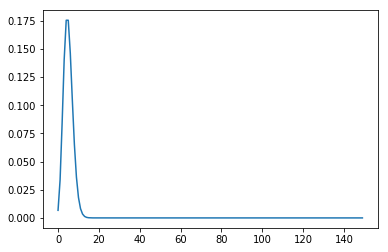

(0.047561471225035706, 0.39346934028736658, 0.01)

In [70]:
plt.plot(p_pl_pdf)
plt.show()


p_em, p_INT, p_rad, 



In [ ]:
dt = 1                                  # time step in units of 10^-10 s = .1 ns = 100ps
tm = 20 * dt                            # mean arrival time
t_f = 1e4 * dt                          # final time to end experiment
t_em = np.linspace(0,t_f,int(t_f/dt))   # discretize time

# electron statistics
l_em = dt/tm                            # lambda parameter for e- poisson distribution
p_em = l_em * np.exp(-l_em)             # probabilty of e- within timestep 

# plasmon statistics
l_pl = 5                                # poissonian lambda for plasmon generation 
                                        # ==thickness/mean free path == avg plsmon number
n_pl_max = 150                          # max plasmons number cutoff
p_pl_pdf = [l_pl**n * np.exp(-l_pl)     # poisson pdf for plasmon generation
            / math.factorial(n) for n in range(n_pl_max)] 


# plasmon poissoinian cumulative distribution function
p_pl_cdf = [0] * n_pl_max             
for i in range(n_pl_max):   
    if i == 0:
            p_pl_cdf[0] = p_pl_pdf[0]
    else:
            p_pl_cdf[i] = p_pl_cdf[i-1] + p_pl_pdf[i]
            
def pick_npl(r, dist = p_pl_cdf):
    """
    draw plasmon number from 
    PARAMETERS
    ----------
    r: random number in [0,1]
    dist: cumulative distribution function sampled (p_pl_cdf by default)

    RETURNS
    -------
    # of plasmons excited
    """
    for p in dist:
        if r > p:
            pass
        else:
            return dist.index(p)
        
# e-h exciton statistics
n_eh = 3                                # number of e-h pairs excited per plasmon

# NV excitation statistics
p_INT = 1 - np.exp(-1/2)                # probability to excite NV
  
# radiation statistics
p_rad = .002                             # emission probability at each timestep


    
NVs = [0] * len(t_em)                    # pre-allocate list for NVs excited at each timestep

em_arrivals = [0] * len(t_em)            # track arrival/excitations times for all modes
pl_arrivals = [0] * len(t_em)
nv_arrivals = [0] * len(t_em)

for i, t in enumerate(t_em):             # loop through discretized time domain    
    for l in range(i):                   # stocastically relax NVs excited at earlier times t_l < t_i
        if NVs[l] != 0:                  # exclude times w/ no excited NVs
            for m, n in enumerate(NVs[l]):
#                 print('Looking backwards to NVs excited at time ' + str(l))
                if random.random() < p_rad and n[1] == 0:
#                     print('Radiative event triggered at time ' + str(t_em[l]))
#                     print('index and excitation times ')
#                     print(m, n)
                    NVs[l][m][1] = t     # assign emission time 
    
    
    if  random.random() < p_em:                   # successful electron nano-crystal interaction 
        npl = pick_npl(random.random())           # number of plasmon modes populated according to p_pl_cdf
        
        NVs[i] = [[t,0] for j in range(npl)       # mark time of arrival 
                  for k in range(n_eh)            
                  if random.random() < p_INT]

        # track all exictations at each time-step
        em_arrivals[i] = 1                        # electrons
        pl_arrivals[i] = npl                      # plasmons

        if len(NVs[i]) == 0:
            NVs[i] = 0
            nv_arrivals[i] = 0
        else:
            nv_arrivals[i] = len(NVs[i])              # NVs
        
        
# plt.plot(p_pl_pdf)
# plt.plot(p_pl_cdf)
# plt.show()
sum(em_arrivals) ,sum(em_arrivals)/len(t_em), p_em

In [ ]:
exicted_NVs = [n for n in NVs if n != [] and n != 0]
rad_times = [t[1] for times in exicted_NVs for t in times if t[1] != 0]
rad_times.sort()

tofe = [rad_times.count(t) for t in t_em]              # emissions per time

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(15,15))

ax[0].plot(t_em, em_arrivals,'.',)
ax[1].plot(t_em, pl_arrivals,'.')
ax[2].plot(t_em, nv_arrivals, '.')
ax[3].plot(t_em, tofe, '.')
ax[4].hist(rad_times, normed=True, bins=50)


ax[0].set_ylabel('Electron interactions')
ax[1].set_ylabel('Plasmon exictations')
ax[2].set_ylabel('NV exictations')
ax[3].set_ylabel('Number of emissions')
ax[4].set_ylabel('Probability of radiation')
plt.show()

# print total: # timesteps, e- arrivals, plasmon excitations, nv_excitations
print("total time is " + str(len(t_em)) + "\n")
print(str(sum(em_arrivals)) + " electrons were excited \n")
print(str(sum(pl_arrivals)) + " plasmons were excited \n")
print(str(sum(nv_arrivals)) + " NV centers were excited \n")
print(str(sum(tofe)) + ' radiation events were detected')

In [ ]:
tau_max = int(len(tofe)/4)
data0 = tofe[tau_max:3 * tau_max]
mu_2 = np.mean(data0)**2
def data(delay):
    """
    Time series day with integer delay
    """
    return tofe[0 + delay: 2 * tau_max + delay]

corr_data = [0] * 2 * tau_max
for i in range(2 * tau_max):
    corr_data[i] = sum(data0[j] * data(i)[j] for j in range(2 * tau_max))/(2 * tau_max * mu_2)

plt.plot(corr_data)
plt.show()


plt.plot(corr_data[tau_max-20:tau_max+20], '.') #zoom into zero delay signal window
plt.show()

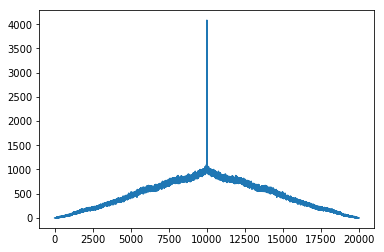

In [63]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
#     return result[int(result.size/2):]
    return result


plt.plot(autocorr(tofe))
plt.show()

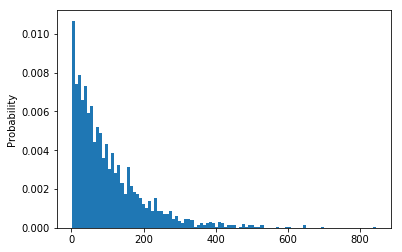

In [42]:
# show that random emission leads to exponential decay of population
emission_times = [0] * int(2e3)             # populate this number of NVs

for i,t in enumerate(t_em):
    for j,e in enumerate(emission_times):
        if e == 0:
            if random.random() < p_rad:
                emission_times[j] = t
                
plt.hist(emission_times, normed=True, bins=100)
plt.ylabel('Probability')
plt.show()

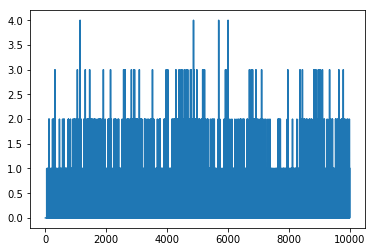

7420

In [67]:
plt.plot(tofe)
plt.show()

not_emissions = 0
for i,t in enumerate(tofe):
    if t == 0:
        not_emissions +=1
not_emissions

In [45]:
max(t_em)

2000.0

In [14]:
dt

1